In [1]:
#数据处理，提取tsv文件
import pandas as pd
import numpy as np
import nltk
import re
import logging
import time 
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from gensim.models import word2vec
from sklearn.cluster import KMeans 
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

In [61]:
#读取数据
train = pd.read_csv("data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("data/testData.tsv", header=0, delimiter="\t", quoting=3)
#unlabeled_train = pd.read_csv( "data/unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )

test.insert(1, 'sentiment', 0)

for i in range(len(test)):
    if int(re.sub("[^0-9]", " ", test["id"][i].split("_")[1])) <= 5:
        test['sentiment']=0
    elif int(re.sub("[^0-9]", " ", test["id"][i].split("_")[1])) > 5:
        test['sentiment']=1
train=train.append(test)
train=train.reset_index(drop=True)
#数据处理，直接把test里面的所有数据标签化
#为保证有足够的数据集，混合label和测试集的全部5万条数据，然后按照622来划分
#可以考虑使用交叉验证
train_set,val_set=train_test_split(train,test_size=0.2,random_state=0)
train_set,test_set=train_test_split(train_set,test_size=0.25,random_state=0)
train_set=train_set.reset_index(drop=True)
val_set=val_set.reset_index(drop=True)
test_set=test_set.reset_index(drop=True)

In [63]:
train_set

,id,sentiment,review
0,"""6801_8""",1,"""\""National Velvet\"" tells the story of Velvet..."
1,"""12065_3""",0,"""Back when I was a kid and I lived with my sis..."
2,"""2627_10""",1,"""I have Never forgot this movie. All these yea..."
3,"""9177_1""",1,"""the only reason i bought this DVD is because ..."
4,"""12071_10""",1,"""Starring: Ann-Margret, Frederic Forrest, Cath..."
...,...,...,...
29995,"""11944_4""",0,"""I rented this film thinking it was the sobbin..."
29996,"""6929_8""",1,"""I like Dylan Moran from his work in Black Boo..."
29997,"""5696_9""",1,"""While many people found this film simply too ..."
29998,"""11982_9""",1,"""Just watched this movie over the weekend, and..."


In [23]:
#数据转换函数
def review_to_words(raw_review, split=False, remove_stopwords=False,lemmatize=False):

    #使用BeautifulSoup库处理掉原始文本，去除<br />等符号
    review_text = BeautifulSoup(raw_review).get_text() 

    #使用正则表达式去除无意义的符号,即只保留a-z和空格，统一为小写
    #实际上可能需要考虑部分符号，比如表情的情感含义？
    review_text = re.sub("[^a-zA-Z]", " ", review_text)
    words=review_text.lower().split() 

    #导入停用词列表使用停用词,剔除掉所有在停用词列表里面的词汇
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops] 
    #先进行词性还原，然后再分割
    if lemmatize:
        temp = []
        temp.append(' '.join(lemmatize_all(words)))
        words=re.sub("[^a-zA-Z]", " ",str(temp) )#.split()
    #if split:
    #    words=words.split()
    return words #如果是词袋，要求输出为单词列表，而不是整个的字符串
    #return(" ".join(words)) 
    
#词性还原
def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(sentence):
        if tag.startswith('NN'):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        elif tag.startswith('R'):
            yield wnl.lemmatize(word, pos='r')
        else:
            yield word

In [64]:
train_reviews = []
val_reviews = [] 

#for review in train_set["review"]:
#    train_reviews += review_to_words(review, remove_stopwords=True,lemmatize=False) 
    
for i in range( 0, train_set["review"].size):
    if( (i+1)%5000 == 0 ):
        print("Review %d of %d\n" % ( i+1, train_set["review"].size )) 
    train_reviews.append( review_to_words( train_set["review"][i],remove_stopwords=True,lemmatize=False))

for i in range(0,val_set["review"].size):
    if( (i+1) % 5000 == 0 ):
        print("Review %d of %d\n" % ( i+1, val_set["review"].size )) 
    val_reviews.append( review_to_words( val_set["review"][i],remove_stopwords=True,lemmatize=False))

E:\anaconda_neve\envs\amls2\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Review 5000 of 30000

Review 10000 of 30000

Review 15000 of 30000

Review 20000 of 30000

Review 25000 of 30000

Review 30000 of 30000

Review 5000 of 10000

Review 10000 of 10000



In [5]:
#Load the punkt tokenizer将段落分解成不同的句子，因为Word2Vec 需要单个句子
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

#定义一个函数，将一篇评论拆分成已解析的句子
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    #函数将一篇评论拆分成已解析的句子。返回句子列表，其中每个句子都是单词列表
    #用NLTK分词器将段落分成句子
    raw_sentences = tokenizer.tokenize(review.strip())

    sentences = []
    for raw_sentence in raw_sentences:
        #如果一个句子是空的，跳过它
        if len(raw_sentence) > 0:
            #否则，调用review_to_wordlist来获取单词列表
            sentences.append( review_to_words( raw_sentence,split=True, remove_stopwords=True, lemmatize=False))
    #返回句子列表(每个句子都是一个单词列表，所以这将返回一个列表列表
    return sentences

sentences = []  
for review in train_set["review"]:
    sentences += review_to_sentences(review, tokenizer)

E:\anaconda_neve\envs\amls2\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [6]:
len(sentences)

315649

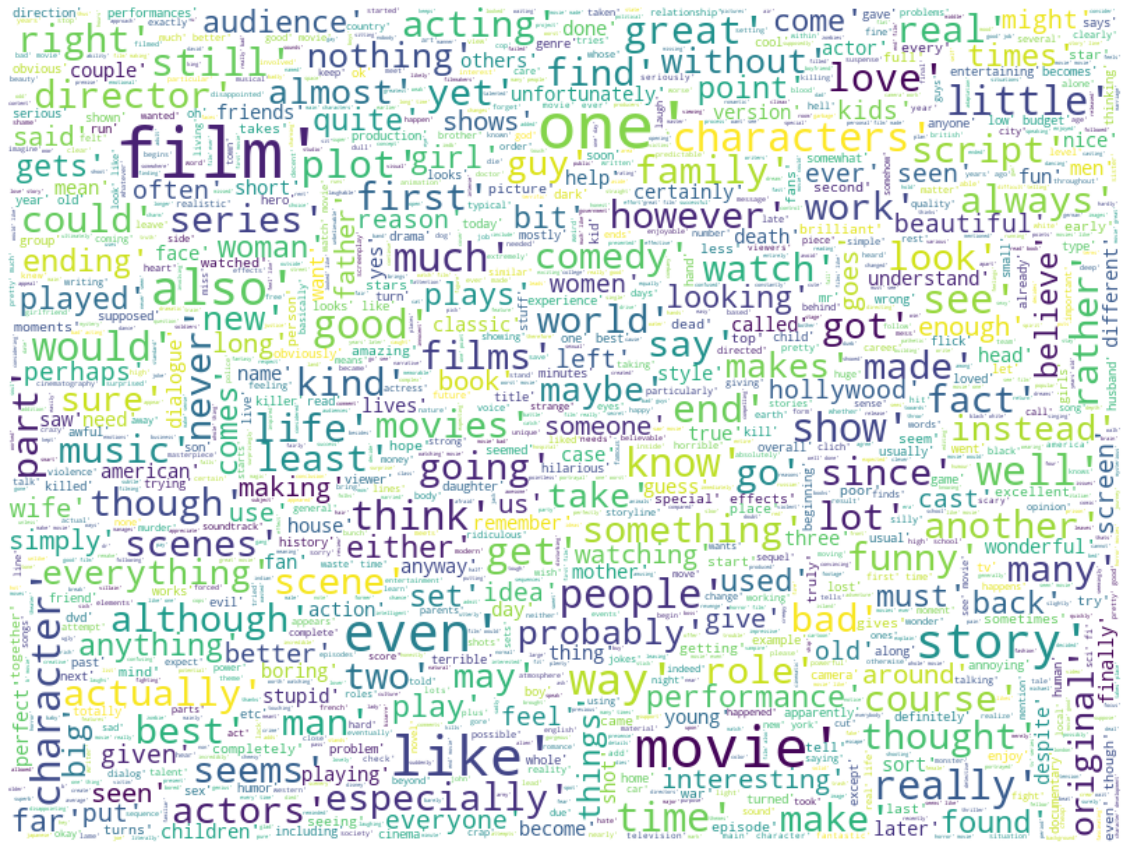

In [7]:
def plot_wordcloud(text):
    wc = WordCloud(background_color="white",# 设置背景颜色
               max_words=2000, # 词云显示的最大词数
               height=600, # 图片高度
               width=800, # 图片宽度
               max_font_size=50, #最大字体     
               stopwords=set(STOPWORDS)) # 设置停用词
    wc.generate(str(text)) #
    fig = plt.figure(figsize=(20,20))
    plt.imshow(wc, interpolation='bilinear') # interpolation='bilinear' 表示插值方法为双线性插值
    plt.axis("off")# 关掉图像的坐标
    plt.show()
plot_wordcloud(str(sentences))

In [8]:
sentences[1]

['film',
 'follows',
 'trains',
 'horse',
 'aid',
 'former',
 'jockey',
 'support',
 'parents',
 'national',
 'velvet',
 'family',
 'film',
 'fact',
 'deter',
 'anyone',
 'typically',
 'views',
 'films',
 'derision']

In [9]:
# 使用Word2Vec算法
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

#设置相关word2vec参数
num_features = 500    # 词向量维度                 
min_word_count = 40   # 最小字数。任何在所有文档中至少出现这么多次的单词都会被忽略。将词汇量限制为有意义的单词                     
num_workers = 4       # 并行运行的线程数量，但 4 到 6 之间应该适用于大多数系统。
context = 10          # 上下文窗口大小；训练算法应该考虑多少上下文词，10 似乎适用于分层 softmax（在一定程度上，越多越好）。                                                                              
downsampling = 1e-3   # 常用词的缩减取样设置，Google 文档建议使用介于 0.00001 和 0.001 之间的值。

#初始化并训练模型(这需要一些时间)
model = word2vec.Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count = min_word_count,window = context, sample = downsampling)

#如果您不打算进一步训练模型，调用init_sims将使模型更加节省内存。
model.init_sims(replace=True)

#创建一个有意义的模型名称并保存模型以备后用会很有帮助。您可以稍后使用Word2Vec.load()加载它
model_name = "300features_40minwords_10context"
model.save(model_name)

2022-04-10 17:59:26,191 : INFO : collecting all words and their counts
2022-04-10 17:59:26,192 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-04-10 17:59:26,209 : INFO : PROGRESS: at sentence #10000, processed 113113 words, keeping 17233 word types
2022-04-10 17:59:26,227 : INFO : PROGRESS: at sentence #20000, processed 223465 words, keeping 24232 word types
2022-04-10 17:59:26,244 : INFO : PROGRESS: at sentence #30000, processed 335807 words, keeping 29404 word types
2022-04-10 17:59:26,262 : INFO : PROGRESS: at sentence #40000, processed 447395 words, keeping 33622 word types
2022-04-10 17:59:26,280 : INFO : PROGRESS: at sentence #50000, processed 559153 words, keeping 37268 word types
2022-04-10 17:59:26,298 : INFO : PROGRESS: at sentence #60000, processed 668649 words, keeping 40445 word types
2022-04-10 17:59:26,319 : INFO : PROGRESS: at sentence #70000, processed 781366 words, keeping 43243 word types
2022-04-10 17:59:26,338 : INFO : PROGRESS: at 

In [10]:
#doesnt_match方法将尝试推断出集合中哪个词与其他词最不相似
model.wv.doesnt_match("man woman child kitchen".split())

'kitchen'

In [11]:
#most_similar函数来深入了解模型的词簇
model.wv.most_similar("man")

[('woman', 0.6950864195823669),
 ('lady', 0.617871880531311),
 ('priest', 0.4800553023815155),
 ('men', 0.47719699144363403),
 ('boy', 0.47343528270721436),
 ('disease', 0.472589373588562),
 ('lover', 0.46386629343032837),
 ('assassin', 0.46093595027923584),
 ('widow', 0.46014243364334106),
 ('coward', 0.4554969072341919)]

In [12]:
#获取模型的大小
model.wv.vectors.shape

(9091, 500)

In [13]:
#读取模型的方法
#model = word2vec.load("300features_40minwords_10context")

In [14]:
#获取具体的变量的特征值
#model.wv["flower"] 

In [15]:
#使用K平均聚类法
start = time.time() # Start time

#将k(num _ clusters)设置为词汇量的1/5，或者每个簇平均5个单词
word_vectors = model.wv.vectors
num_clusters = int(word_vectors.shape[0] / 5)

#初始化一个k-means对象，并使用它来提取质心,传入kmean的必须是int类型
kmeans_clustering = KMeans( n_clusters = num_clusters ) 
idx = kmeans_clustering.fit_predict( word_vectors )

#获取结束时间并打印该过程花费的时间
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

Time taken for K Means clustering:  295.612824678421 seconds.


In [16]:
num_clusters = int(word_vectors.shape[0] / 5)
num_clusters

1818

In [17]:
#创建一个单词/索引字典，将每个词汇单词映射到一个簇号                                                                                            
word_centroid_map = dict(zip( model.wv.index_to_key, idx ))

# For the first 10 clusters
for cluster in range(0,10):
    #打印簇编号
    print("\nCluster %d" % cluster)
    #找出该簇编号的所有单词，并将其打印出来
    words = []
    for i in range(0,len(word_centroid_map.values())):
        if(list(word_centroid_map.values())[i] == cluster):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['alive']

Cluster 1
['cardboard', 'wardrobe', 'insert', 'prop', 'faux', 'shamelessly']

Cluster 2
['resident', 'defeated', 'duel', 'mac', 'commando', 'luther']

Cluster 3
['l', 'w', 'legendary', 'lucas', 'alongside', 'cecil', 'demille']

Cluster 4
['body', 'attack', 'victims', 'flesh', 'bodies', 'attacks', 'causing', 'corpses', 'wounds', 'spree']

Cluster 5
['relationship', 'emotions', 'feelings', 'friendship', 'emotionally', 'thoughts', 'circumstances', 'sides']

Cluster 6
['commentary', 'format', 'releases', 'volume', 'update', 'domain', 'prints', 'ratio', 'alpha']

Cluster 7
['al', 'pacino', 'comedian', 'madonna', 'goldberg', 'kramer', 'foxx', 'shatner', 'marlon', 'whoopi', 'jolie', 'resume', 'kilmer', 'versatile']

Cluster 8
['provide', 'provided', 'providing']

Cluster 9
['heads', 'blow', 'snakes', 'dig', 'remove', 'mouths', 'surf', 'flames', 'pointing', 'explode', 'stab', 'bleeding', 'wipe']


In [18]:
word_centroid_map = dict(zip( model.wv.index_to_key, idx ))
list(word_centroid_map.values())[2]

536

In [73]:
#质心袋函数将评论转换为质心袋。这就像 Bag of Words 一样工作，但使用语义相关的集群而不是单个单词
def create_bag_of_centroids( wordlist, word_centroid_map ):

    #聚类的数量等于单词/质心图中的最高聚类索引
    num_centroids = max( word_centroid_map.values() ) + 1

    #预分配质心矢量包(为了速度)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    
    #循环评论中的单词。如果这个单词在词汇表中，找到它属于哪个簇，并将该簇的计数加1
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
               
    return bag_of_centroids
#为质心的训练集包预先分配一个数组(为了速度) 
train_centroids = np.zeros( (train_set["review"].size, num_clusters),dtype="float32" )

#将训练集评论转换成质心包
counter = 0
for review in train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

#处理测试集 
test_centroids = np.zeros(( val_set["review"].size, num_clusters), dtype="float32" )

counter = 0
for review in val_reviews:
    test_centroids[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

In [68]:
#拟合随机森林并提取预测
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
forest = forest.fit(train_centroids,train_set["sentiment"])
result = forest.predict(test_centroids)

output = pd.DataFrame(data={"id":val_set["id"], "sentiment":result})
output.to_csv( "BagOfCentroids.csv", index=False, quoting=3 )

Fitting a random forest to labeled training data...


In [69]:
#准确率的函数
def classified_correct(model, i):
    return (model["sentiment"][i] == 0 and int(model["id"][i].split("_")[1]) <= 5) or \
           (model["sentiment"][i] == 1 and int(model["id"][i].split("_")[1]) > 5)

model = pd.read_csv("BagOfCentroids.csv");
correct = np.array([classified_correct(model,i) for i in range(model.shape[0])])
print(correct.sum() / model.shape[0]) # the accuracy

0.5298


In [72]:
model

,id,sentiment
0,6648_7,1
1,8511_10,1
2,10432_4,1
3,2331_9,1
4,12008_1,0
...,...,...
9995,2072_8,1
9996,2170_1,1
9997,484_8,1
9998,967_2,1
